### Text analytics

In this unit, we will look at different techniques for getting insights from text data. After walking you through some common preprocessing steps for text data, we will explore different tools for extracting information about the content of text documents. First, we will look at word frequencies and then detect word combinations that frequently appear together. Next, we will learn how to weight word frequencies according to the tf-idf model. This model provides more informative statistics about key terms in a given document in our dataset compared to plain word frequencies.

We will work with publicly available press releases by the Swiss Federal Council about the Coronavirus 2019 epidemic.

In [1]:
# A first look at the data
# Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Path to the data
PATH_DATA = os.path.join('c2_press_releases_covid19.csv')

# Load press releases
df = pd.read_csv(PATH_DATA)

print('Data shape: ',df.shape)

Data shape:  (61, 4)


In [2]:
# Print a few samples

df.head(3)

#Alternatively we may use the .sample method which gives out 3 random samples

df.sample(3)

,title,url,pub_date,text
27,Coronavirus: Masks compulsory on public transp...,https://www.admin.ch/gov/en/start/documentatio...,2020-07-01,"(Last modification 22.07.2020) Bern, 01.07.202..."
14,Coronavirus: Switzerland reaches agreement wit...,https://www.admin.ch/gov/en/start/documentatio...,2020-05-13,"Bern, 13.05.2020 - Switzerland plans to open a..."
20,Coronavirus: Switzerland to reopen its borders...,https://www.admin.ch/gov/en/start/documentatio...,2020-06-05,"Bern, 05.06.2020 - Federal Councillor Karin Ke..."


We can adjust the column width displayed in our dataframe using the pandas.set_option() method and the display.max_colwidth parameter.

In [3]:
# Change display option for max_colwidth

pd.set_option('display.max_colwidth', 500)

#To reset the display options to the default ones, use this command: pd.reset_option('display.max_colwidth')

In [4]:
# Remove 'url' column

df.drop(labels = ['url'],    # specify which columns to drop
        axis=1,              # drops labels from the columns
        inplace=True         # apply changes to the original df
       )

# Print data shape
print('Data shape: ',df.shape)

Data shape:  (61, 3)


In [5]:
# Show a few samples
df.sample(3)

,title,pub_date,text
15,"Coronavirus: Switzerland responds to humanitarian needs and supports the development of diagnostics, therapeutics and vaccines",2020-05-13,"Bern, 13.05.2020 - At its meeting of 13 May 2020, the Federal Council approved the allocation of CHF 175 million for the global fight against the COVID-19 pandemic. These funds will be used for humanitarian aid, the development and production of diagnostics, therapeutics and vaccines, and efforts aimed at ensuring equitable access to these medical solutions worldwide. The CHF 175 million is part of a CHF 400 million package approved by the Federal Council two weeks ago. On 29 April 2020, the..."
10,Corona virus: Switzerland set to take part in 2021 Olympic Games and Dubai World Expo,2020-04-29,"Bern, 29.04.2020 - Because of the COVID-19 pandemic, a number of global events are being postponed – including the 2020 Summer Olympics and Paralympics in Tokyo and Expo 2020 in Dubai. The Federal Council has confirmed that Switzerland will be showcasing itself at both major events which will now be held in 2021. It also emphasized the importance of such events in terms of economic recovery for the international markets. The International Olympic Committee, the International Paralympic Commi..."
22,Coronavirus: Move towards normalisation and simplified basic rules to protect the population,2020-06-19,"Bern, 19.06.2020 - As of Monday, 22 June, the measures put in place to tackle the coronavirus will for the most part be lifted. Only the ban on large-scale events will remain in place until the end of August. This follows the decisions taken by the Federal Council at its meeting on 19 June in view of the continuing low level of new cases. All publicly accessible venues must have a set of precautionary measures in place. However, the Federal Council has simplified the applicable requirements...."


We usually call a dataset of text data corpus (plural corpora) and samples of text documents. Our corpus has 61 documents. Below we check the data for duplicated entries and missing values.

In [6]:
# Check for duplicated entries

print('Found {} duplicated entries.'.format(df.duplicated().sum()))


Found 0 duplicated entries.


In [7]:
# Check for missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     61 non-null     object
 1   pub_date  61 non-null     object
 2   text      61 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [8]:
# Convert pub_date to datetime dtype

df['pub_date'] = pd.to_datetime(df.pub_date)

# Check data types again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     61 non-null     object        
 1   pub_date  61 non-null     datetime64[ns]
 2   text      61 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.6+ KB


We converted the column pub_date to datetime. Below, we see that the earliest press release is from February 28, 2020, and the last one from August 18, 2021.

In [9]:
# Print earliest publication date

df['pub_date'].min()

Timestamp('2020-02-28 00:00:00')

In [10]:
# Print latest publication date

df['pub_date'].max()

Timestamp('2021-08-18 00:00:00')

#### Text length: 
You may be wondering about the length of the press releases. Do they all use the same number of words or characters? Let’s look at the first press release.

In [11]:
print(df['text'][0])

Bern, 28.02.2020 - An extraordinary meeting of the Federal Council was held today, 28 February. In view of the current situation and the spread of the coronavirus, the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act. Large-scale events involving more than 1000 people are to be banned. The ban comes into immediate effect and will apply at least until 15 March. The Federal Council's top priority is to protect the population. It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act. This enables the Federal Council, in consultation with the cantons, to order measures that are normally the responsibility of the cantons.The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather. This ban on events comes into immediate effect and will apply at least until 15 March. The canton

We will start by splitting this document on whitespace using the split function. The process of splitting text into its constituent terms is called tokenization and the constituent terms are called tokens.

In [12]:
# Split document on whitespace

print(df['text'][0].split())

['Bern,', '28.02.2020', '-', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today,', '28', 'February.', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus,', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned.', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March.', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population.', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'This', 'enables', 'the', 'Federal',

In [13]:
# Count the number of tokens in document
len(df['text'][0].split())

450

In [14]:
# In the next cell, we use the apply function to count the number of tokens in each press release.

df['text'].apply(lambda x: len(x.split()))


0      450
1     1982
2     1393
3      518
4      997
      ... 
56     983
57     105
58    2821
59    1675
60     534
Name: text, Length: 61, dtype: int64

The following plot shows the distribution of token counts in all of the press releases.



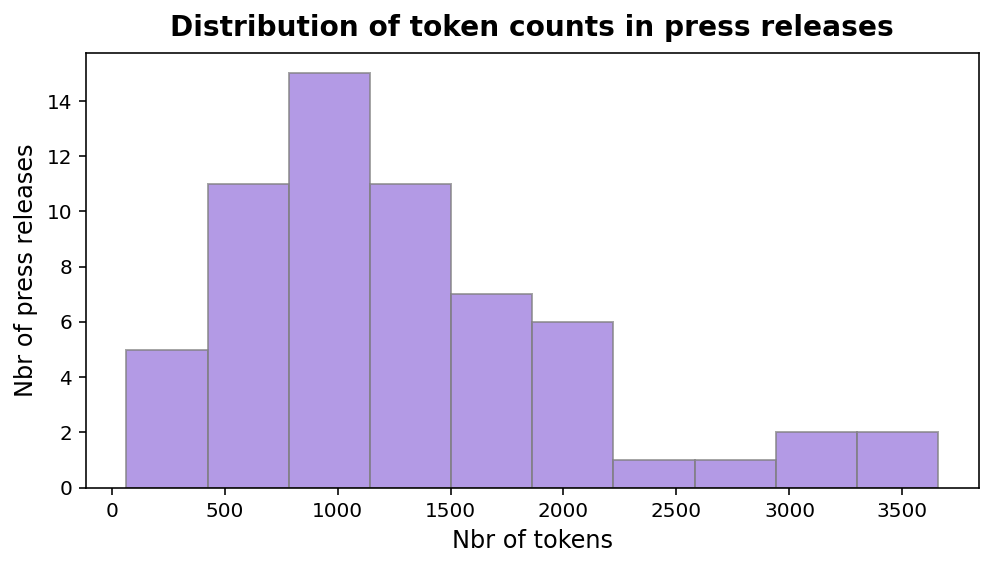

In [15]:
# Plot the number of tokens per press release

# Barplot and font specifications
barplot_specs = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
label_specs   = {"fontsize": 12}
title_specs   = {"fontsize": 14, "fontweight": "bold", "y": 1.01}

plt.figure(figsize=(8,4))

plt.hist(df['text'].apply(lambda x:len(x.split())), **barplot_specs)
plt.xlabel('Nbr of tokens', **label_specs)
plt.ylabel('Nbr of press releases',**label_specs)
plt.title('Distribution of token counts in press releases',**title_specs)
plt.show()

In [16]:
# we use the describe method to get descriptive statistics for token counts in press releases.
df['text'].apply(lambda x: len(x.split())).describe()

count      61.000000
mean     1287.098361
std       800.633597
min        66.000000
25%       752.000000
50%      1132.000000
75%      1706.000000
max      3658.000000
Name: text, dtype: float64

The shortest press release has 66 tokens, and the longest has 3’658 tokens. The median number of tokens per press release is 1’132.

#### Word frequencies

Now, we would like to know a bit more about what each press release is about. One way to answer this question would be to look at the most frequent tokens in each press release. Tokens that are mentioned several times in a text may reveal some information about the content of each press release. Let’s start with at an example of a press release from the data.

In [17]:
sample = df['text'][0]
# Split text on whitespace
print(sample.split()[0:150])
# Note: we show only the first 150 tokens

['Bern,', '28.02.2020', '-', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today,', '28', 'February.', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus,', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned.', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March.', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population.', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act.', 'This', 'enables', 'the', 'Federal',

This approach doesn’t separate punctuation from adjacent words. For example, in the following tokens: February., March., Act., etc., the period . wasn’t separated from the preceding token. This is not great as it means February. and February won’t be counted together.

Below, we replace characters such as commas, periods, parentheses and single hyphens (-) with whitespace, using regular expressions.

In [18]:
import re

# Replace punctuation marks (,.()) with whitespace
clean_sample = re.sub(r"[,.()]", # regex pattern
                      " ",       # replace with whitespace
                      sample     # string
                     )

# Replace single hyphens with whitespace
clean_sample = re.sub(r"\s-\s",      # regex pattern
                      " ",           # replace with whitespace
                      clean_sample   # string
                     )

# Print clean_sample
print(clean_sample)

Bern  28 02 2020 An extraordinary meeting of the Federal Council was held today  28 February  In view of the current situation and the spread of the coronavirus  the Federal Council has categorised the situation in Switzerland as ‘special’ in terms of the Epidemics Act  Large-scale events involving more than 1000 people are to be banned  The ban comes into immediate effect and will apply at least until 15 March  The Federal Council's top priority is to protect the population  It is responding to the latest developments in the coronavirus epidemic and has categorised the situation in Switzerland as ‘special' in terms of the Epidemics Act  This enables the Federal Council  in consultation with the cantons  to order measures that are normally the responsibility of the cantons The Federal Council is banning public and private events in Switzerland at which more than 1000 people would gather  This ban on events comes into immediate effect and will apply at least until 15 March  The cantons 

In [19]:
# Split clean_sample on whitespace
print(clean_sample.split()[0:150])

# Note: we show only the first 150 tokens

['Bern', '28', '02', '2020', 'An', 'extraordinary', 'meeting', 'of', 'the', 'Federal', 'Council', 'was', 'held', 'today', '28', 'February', 'In', 'view', 'of', 'the', 'current', 'situation', 'and', 'the', 'spread', 'of', 'the', 'coronavirus', 'the', 'Federal', 'Council', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', '‘special’', 'in', 'terms', 'of', 'the', 'Epidemics', 'Act', 'Large-scale', 'events', 'involving', 'more', 'than', '1000', 'people', 'are', 'to', 'be', 'banned', 'The', 'ban', 'comes', 'into', 'immediate', 'effect', 'and', 'will', 'apply', 'at', 'least', 'until', '15', 'March', 'The', 'Federal', "Council's", 'top', 'priority', 'is', 'to', 'protect', 'the', 'population', 'It', 'is', 'responding', 'to', 'the', 'latest', 'developments', 'in', 'the', 'coronavirus', 'epidemic', 'and', 'has', 'categorised', 'the', 'situation', 'in', 'Switzerland', 'as', "‘special'", 'in', 'terms', 'of', 'the', 'Epidemics', 'Act', 'This', 'enables', 'the', 'Federal', 'Counci

In [20]:
# We will use the Counter object from the collections module.
from collections import Counter

# Print top-25 most frequent tokens in clean_sample
Counter(clean_sample.split()).most_common(25)

[('the', 39),
 ('in', 20),
 ('to', 15),
 ('of', 12),
 ('Switzerland', 11),
 ('Federal', 10),
 ('and', 10),
 ('is', 10),
 ('The', 9),
 ('Council', 8),
 ('public', 8),
 ('events', 7),
 ('people', 7),
 ('at', 7),
 ('cantons', 6),
 ('or', 6),
 ('than', 5),
 ('1000', 5),
 ('are', 5),
 ('ban', 5),
 ('will', 5),
 ('situation', 4),
 ('It', 4),
 ('This', 4),
 ('with', 4)]

Here are a few observations:

The words “The” and “the” were counted separately. However, there is no advantage in tracking “The” and “the” separately.
Words such as: “the”, “in”, “to”, etc. are among the most common tokens. These words don’t help us understand what a press release is about.

#### Case folding


It is common to convert documents to lowercase

In [21]:
# Case folding
processed_sample = clean_sample.lower()

print("Convert to lowercase: \n\n{}\n".format(processed_sample))

Convert to lowercase: 

bern  28 02 2020 an extraordinary meeting of the federal council was held today  28 february  in view of the current situation and the spread of the coronavirus  the federal council has categorised the situation in switzerland as ‘special’ in terms of the epidemics act  large-scale events involving more than 1000 people are to be banned  the ban comes into immediate effect and will apply at least until 15 march  the federal council's top priority is to protect the population  it is responding to the latest developments in the coronavirus epidemic and has categorised the situation in switzerland as ‘special' in terms of the epidemics act  this enables the federal council  in consultation with the cantons  to order measures that are normally the responsibility of the cantons the federal council is banning public and private events in switzerland at which more than 1000 people would gather  this ban on events comes into immediate effect and will apply at least unti

#### Stop words

Words such as “the”, “in”, “to”, are commonly referred to as stop words and are necessary for a sentence to make sense from a grammatical point of view. However, they are very “frequent” and usually “uninformative”. Hence, in most cases, it is useful to remove them from text.

In [22]:
# Load English stopwords from nltk

import nltk

nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords

stopwords_english = stopwords.words("english")

# Print stopwords

print("{} stopwords in NLTK's list.\n".format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

In [23]:
# We can remove stop words from our document using list comprehensions.

# Use a list comprehension to remove stopwords from processed_sample

processed_sample_tokens = [tok for tok in processed_sample.split() if tok not in stopwords_english]
print(processed_sample_tokens)

['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal', 'council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread', 'coronavirus', 'federal', 'council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms', 'epidemics', 'act', 'large-scale', 'events', 'involving', '1000', 'people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'federal', "council's", 'top', 'priority', 'protect', 'population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms', 'epidemics', 'act', 'enables', 'federal', 'council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal', 'council', 'banning', 'public', 'private', 'events', 'switzerland', '1000', 'people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons', 'responsible', 'enforcing', 'ban'

So far, we removed punctuation marks, converted text to lowercase, and removed stop words. Let’s recount words in our text sample.

In [24]:
# Print top-25 most frequent tokens in processed_sample_tokens

Counter(processed_sample_tokens).most_common(25)

[('switzerland', 11),
 ('federal', 10),
 ('council', 8),
 ('public', 8),
 ('events', 7),
 ('people', 7),
 ('cantons', 6),
 ('1000', 5),
 ('ban', 5),
 ('situation', 4),
 ('private', 4),
 ('would', 4),
 ('gather', 4),
 ('event', 4),
 ('held', 3),
 ('spread', 3),
 ('coronavirus', 3),
 ('categorised', 3),
 ('terms', 3),
 ('epidemics', 3),
 ('act', 3),
 ('comes', 3),
 ('immediate', 3),
 ('effect', 3),
 ('apply', 3)]

This function takes a document, removes common punctuation marks, converts text to lowercase, removes stopwords, and splits on whitespace.

In [25]:
# Define preprocess_text function

def preprocess_text(text):
    
    '''
    This function preprocesses raw samples of text:
    - Converts to lowercase
    - Replaces common punctuation marks with whitespace
    - Removes stop words
    - Splits text on whitespace
    
    INPUT: 
    - text: "raw" text (string)
    
    OUTPUT:
    - processed_sample_tokens: list of tokens (list of strings)
    '''
    
    # Convert to lowercase
    clean_text = text.lower()
    
    # Replace common punctuation marks with whitespace
    clean_text = re.sub(r"[,.()]"," ", clean_text)
    
    # Replace single hyphens with whitespace
    clean_text = re.sub(r"\s-\s"," ", clean_text)
    
    # Remove stop words and split on whitespace
    processed_sample_tokens = [tok for tok in clean_text.split() if tok not in stopwords_english]
    
    return processed_sample_tokens

Let’s test this function with an example. Below we sample a press release randomly from the dataset, using the random library.

In [26]:
# Sample a press release randomly from the data
import random
sample =  df.iloc[random.randint(0,len(df)-1),2]

print(preprocess_text(sample)[0:150])

# Note: we show only the first 150 tokens

['bern', '18', '12', '2020', 'epidemiological', 'situation', 'cause', 'great', 'concern', 'number', 'infections', 'high', 'continuing', 'rise', 'hospitals', 'healthcare', 'workers', 'extreme', 'pressure', 'weeks', 'festive', 'period', 'increases', 'risk', 'even', 'rapid', 'rise', 'cases', 'meeting', '18', 'december', 'federal', 'council', 'consulting', 'cantons', 'decided', 'tighten', 'national', 'measures', 'spread', 'coronavirus', 'even', 'aim', 'considerably', 'reduce', 'number', 'contacts', 'tuesday', '22', 'december', 'restaurants', 'bars', 'cultural', 'venues', 'sports', 'leisure', 'facilities', 'close', 'federal', 'council', 'also', 'expanded', 'use', 'rapid', 'tests', 'aim', 'measures', 'reduce', 'case', 'numbers', 'rapidly', 'substantially', 'protect', 'people', 'virus', 'safeguard', 'health', 'service', 'relieve', 'pressure', 'healthcare', 'workers', 'cantons', 'must', 'able', 'guarantee', 'times', 'tests', 'available', 'contacts', 'traced', 'isolation', 'quarantine', 'requir

In [27]:
# We can now use this function to process all press releases. 
# 1st alternative (using list comprehensions)

preprocessed_press_releases = [preprocess_text(doc) for doc in df['text']]

# Show an example of processed and tokenized text
print(preprocessed_press_releases[0])

['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal', 'council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread', 'coronavirus', 'federal', 'council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms', 'epidemics', 'act', 'large-scale', 'events', 'involving', '1000', 'people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'federal', "council's", 'top', 'priority', 'protect', 'population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms', 'epidemics', 'act', 'enables', 'federal', 'council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal', 'council', 'banning', 'public', 'private', 'events', 'switzerland', '1000', 'people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons', 'responsible', 'enforcing', 'ban'

In [28]:
# 2nd alternative (using the apply method)

df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x))

# Show an example of preprocessed and tokenized text
df.sample()

,title,pub_date,text,clean_text
40,Coronavirus: Federal Council introduces 7pm closing time and closures on Sundays and public holidays,2020-12-11,"Bern, 11.12.2020 - At its meeting on 11 December, the Federal Council tightened its measures to counter the spread of the coronavirus. The aim is to reduce the level of contact between people and to prevent people from gathering together. Restaurants and bars, shops and markets, museums and libraries, and sports and leisure facilities will be required to close at 7pm from tomorrow, Saturday, 12 December. With the exception of restaurants and bars they must also remain closed on Sundays and p...","[bern, 11, 12, 2020, meeting, 11, december, federal, council, tightened, measures, counter, spread, coronavirus, aim, reduce, level, contact, people, prevent, people, gathering, together, restaurants, bars, shops, markets, museums, libraries, sports, leisure, facilities, required, close, 7pm, tomorrow, saturday, 12, december, exception, restaurants, bars, must, also, remain, closed, sundays, public, holidays, cantons, favourable, epidemiological, situation, may, extend, closing, time, 11pm, ..."


#### Collocations

We can look for combinations of words that frequently appear together, such as Federal Council, private event, Covid certificate, etc. We will use Gensim’s Phrases model to detect collocations in our corpus. model.phrases will identify the most common collocations and join the constituent tokens into a single token, using the “_” glue character.

In [29]:
# Import Gensim and Phrases

import gensim
from gensim.models import Phrases

# Find common collocations in press releases

# Create an instance of the Phrases model
n_gram_model = Phrases(preprocessed_press_releases,       # Expected input format: list of tokenized texts
                       min_count=5,                       # Keeps only collocations with at least min_counts 
                       delimiter=b'_')                    # Glue character used to join collocation tokens

In [30]:
#We apply the n_gram_model model to the press releases texts.
# Apply Phrases to press releases

preprocessed_press_releases_collocations = [n_gram_model[doc] for doc in preprocessed_press_releases]
# Add processed press releases (with collocations) to dataframe

df['clean_text'] = preprocessed_press_releases_collocations
print(preprocessed_press_releases_collocations[0])


['bern', '28', '02', '2020', 'extraordinary', 'meeting', 'federal_council', 'held', 'today', '28', 'february', 'view', 'current', 'situation', 'spread_coronavirus', 'federal_council', 'categorised', 'situation', 'switzerland', '‘special’', 'terms_epidemics', 'act', 'large-scale_events', 'involving', '1000_people', 'banned', 'ban', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', "federal_council's", 'top_priority', 'protect_population', 'responding', 'latest', 'developments', 'coronavirus', 'epidemic', 'categorised', 'situation', 'switzerland', "‘special'", 'terms_epidemics', 'act', 'enables', 'federal_council', 'consultation', 'cantons', 'order', 'measures', 'normally', 'responsibility', 'cantons', 'federal_council', 'banning', 'public', 'private_events', 'switzerland', '1000_people', 'would', 'gather', 'ban', 'events', 'comes', 'immediate', 'effect', 'apply', 'least', '15', 'march', 'cantons_responsible', 'enforcing', 'ban', 'case', 'public', 'private_events', 'fewer_

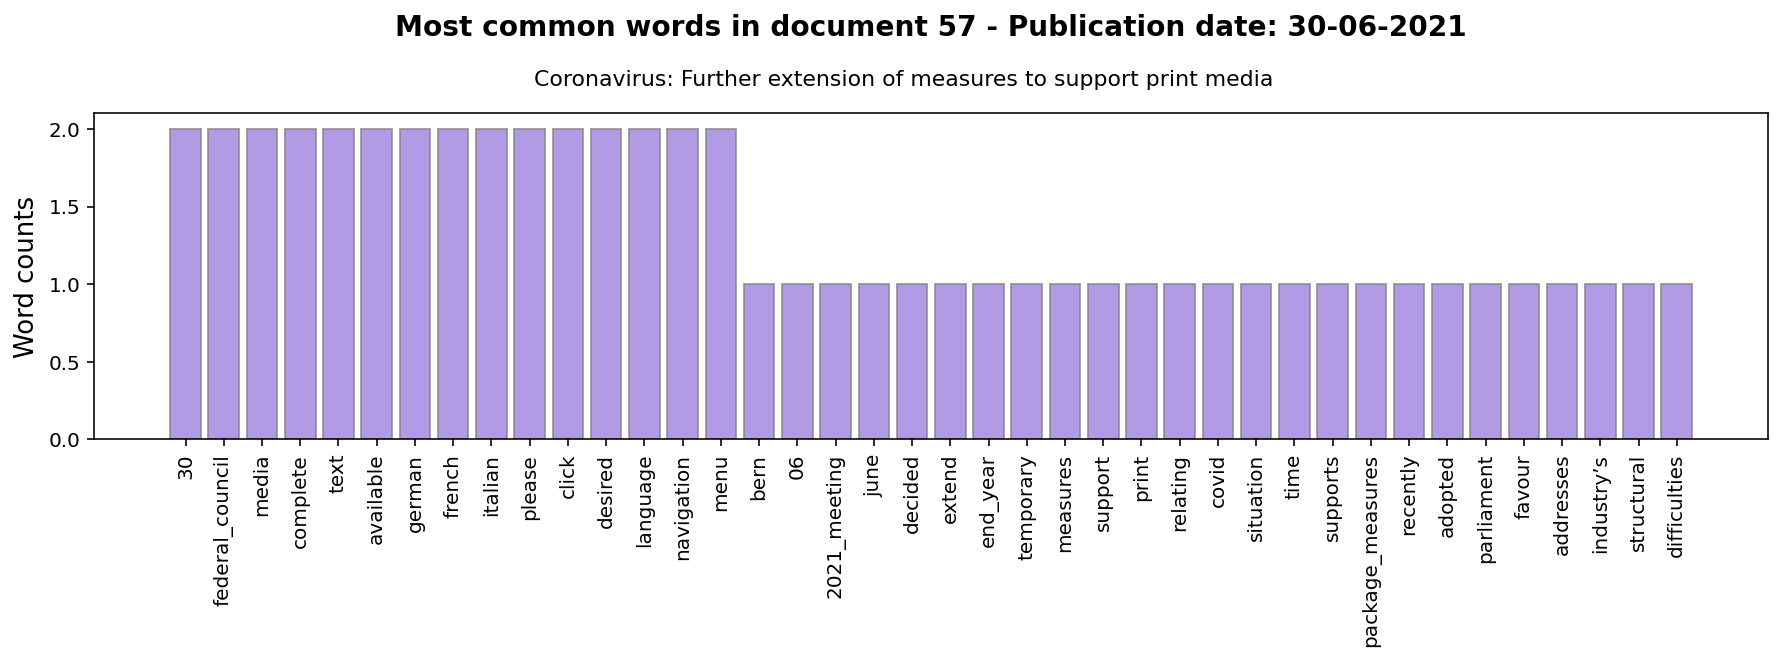

In [31]:
# Below we count and plot the most frequent words in a randomly selected press release. This time we include collocations in the most common words.

# Generates a random integer between 0 and len(df)
idx = random.randint(0,len(df))

# Find top-50 most common words
w = Counter(preprocessed_press_releases_collocations[idx]).most_common(50)

# Plots top words

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))
plt.bar(*zip(*w), **barplot_specs)
plt.title('Most common words in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Word counts', **label_specs)
plt.xticks(rotation=90)
plt.show()

In [32]:
# Do the topmost frequent words help guess the “topic” of the press release?
# Print the original unprocessed text corresponding to the previous plot 
print('Printing document {}:\n'.format(idx))
print(df.iloc[idx,2])

Printing document 57:

Bern, 30.06.2021 - At its meeting on 30 June, the Federal Council decided to extend until the end of the year the temporary measures in support of the print media relating to the COVID situation. At the same time, the Federal Council supports the package of measures recently adopted by Parliament in favour of the media as it addresses the industry’s structural difficulties. The complete text is available in German, French and Italian. Please click on the desired language in the navigation menu above. The complete text is available in German, French and Italian. Please click on the desired language in the navigation menu above.


#### Tf-idf weighting model

We would like to give the words specific to a given press release higher weights so that we can discriminate it from other press releases in the same corpus.

Therefore, we may want to:

* Diminish the importance of widespread words over the entire corpus of documents as they could shadow rarer yet more interesting words.
* Focus more on rare words across the corpus, as they could be more informative about the content of individual press releases.

This is known as tf–idf weighting model, where tf stands for term-frequency and idf stands for inverse document frequency and is a “measure” of a word’s “rarity” in the corpus. The higher the idf, the “rarer” the word in the corpus. In other words, tf-idf model favors words, or terms, that are frequent in few documents.

We start by importing the tf-idf model from scikit-learn and creating an instance of it.

In [33]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the tf-idf model
tfidf = TfidfVectorizer()

tf-idf model expects non-tokenized text; using it directly with preprocessed_press_releases_collocations would throw an error. This is why below we use the join() function to join lists of tokens into single strings.

In [34]:
# Join lists of tokens into single strings (for each press release)

X = [" ".join([w for w in doc]) for doc in preprocessed_press_releases_collocations]
# Fit model on text data
tfidf.fit(X);

 couple of things happen once we call the fit method of TfidfVectorizer() on our text data.

First, the TfidfVectorizer model tokenizes texts and builds the vocabulary. The vocabulary is the list of unique words in our corpus. We can check which words are part of the vocabulary using the get_feature_names_out() method.

In [35]:
# Show vocabulary
vocabulary = tfidf.get_feature_names_out()

# Print vocabulary length
print('Vocabulary length: {}\n'.format(len(vocabulary)))

# Show a few words from vocabulary
print('Show a few words from vocabulary:')
print(vocabulary[0:500:10])

Vocabulary length: 3947

Show a few words from vocabulary:
['000' '07' '11' '128' '16' '19_april' '1_july' '2021' '23' '27_may'
 '30_people' '480' '5_million' '72' '85' 'able' 'accept' 'accompanying'
 'act' 'acute' 'additional' 'adjustment' 'adolescents' 'advantages'
 'affects' 'age_16' 'ahead' 'airline' 'allfollowing' 'allowedfrom'
 'always' 'amounting' 'announced' 'anyone' 'appeared' 'appointment'
 'april_2020' 'armed' 'article' 'assessments' 'assume_cost'
 'asymptomatic_persons' 'attention' 'austrian' 'automatically'
 'aviation_industry' 'back' 'banned' 'basically' 'beds']


In [36]:
# To transform each sample of text in our corpus into its tf-idf representation, we call the transform() method.

# Get tf-idf representation of text data
X_tfidf = tfidf.transform(X)
print(X_tfidf.shape)


(61, 3947)


The shape of X_tfidf is (61, 3947). Each row corresponds to a text document from the corpus and each column to a word in the vocabulary.

We can check what X_tfidf looks like using the following code snippet.



In [37]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(),
                        columns=vocabulary)
df_tfidf.head()

,000,000_people,01,02,03,04,04_2020,05,05_2020,06,...,young_people,younger,youth,zealand,zero,zones,zoos,zoos_botanical,zoosin,zurich
0,0.000000,0.0,0.0,0.054617,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.014843,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.032799,0.0,0.0,0.000000,0.016399,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.035813,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.123561,0.0,0.0,0.000000,0.020593,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.064655,0.0,0.0,0.0,0.0,0.0


#### Top words according to tf-idf scores

Instead of looking at the topmost frequent words in each press release, we will focus on words with the highest tf-idf scores in each document. Remember, tf-idf favors words that are frequent in few press releases. We hope that this way, the importance of widespread words across all press releases (such as “Federal Council”, etc.) will be diminished, letting us focus on other more informative words about the content of individual press releases.

Below we plot the top 50 words according to the tf-idf scores.

 


In [38]:
# Set number of top words to plot
N = 50

print('Printing top words according to tf-idf for document {}.'.format(idx))


Printing top words according to tf-idf for document 57.


In [39]:
# Sort indexes according to tf-idf scores for document idx

index_sorted = np.argsort(df_tfidf.iloc[idx,:])[::-1]  # descending order

# Print sorted indexes according to tf-idf
index_sorted.values

array([2232, 2025,  722, ..., 2621, 2620,    0], dtype=int64)

In [40]:
# Sort words in vocabulary according to tf-idf

features_sorted = np.array(vocabulary)[index_sorted][0:N]

# Print top words according to tf-idf scores
print(features_sorted)

['menu' 'language' 'click' 'please' 'media' 'italian' 'navigation'
 'french' 'german' 'text' 'desired' 'complete' '30' 'available'
 'structural' 'addresses' 'difficulties' 'print' 'relating' 'recently'
 'favour' 'supports' 'end_year' 'package_measures' 'industry' 'temporary'
 'extend' '2021_meeting' '06' 'parliament' 'adopted' 'federal_council'
 'support' 'june' 'time' 'situation' 'decided' 'covid' 'measures' 'bern'
 'entrance' 'estate' 'entry' 'estimated' 'entry_requirements'
 'establishments' 'etc' 'essential_everyday' 'entitlement' 'entitled']


In [41]:
# Sort tf-idf scores (descending order)

tfidf_weights_sorted = df_tfidf.iloc[idx,:][index_sorted][0:N]
print(tfidf_weights_sorted)

menu                  0.245256
language              0.245256
click                 0.245256
please                0.245256
media                 0.245256
italian               0.245256
navigation            0.245256
french                0.245256
german                0.230626
text                  0.230626
desired               0.230626
complete              0.218673
30                    0.167981
available             0.146646
structural            0.145350
addresses             0.145350
difficulties          0.145350
print                 0.132059
relating              0.132059
recently              0.132059
favour                0.122628
supports              0.122628
end_year              0.115313
package_measures      0.109337
industry              0.109337
temporary             0.104283
extend                0.099906
2021_meeting          0.096045
06                    0.089467
parliament            0.086615
adopted               0.081561
federal_council       0.065562
support 

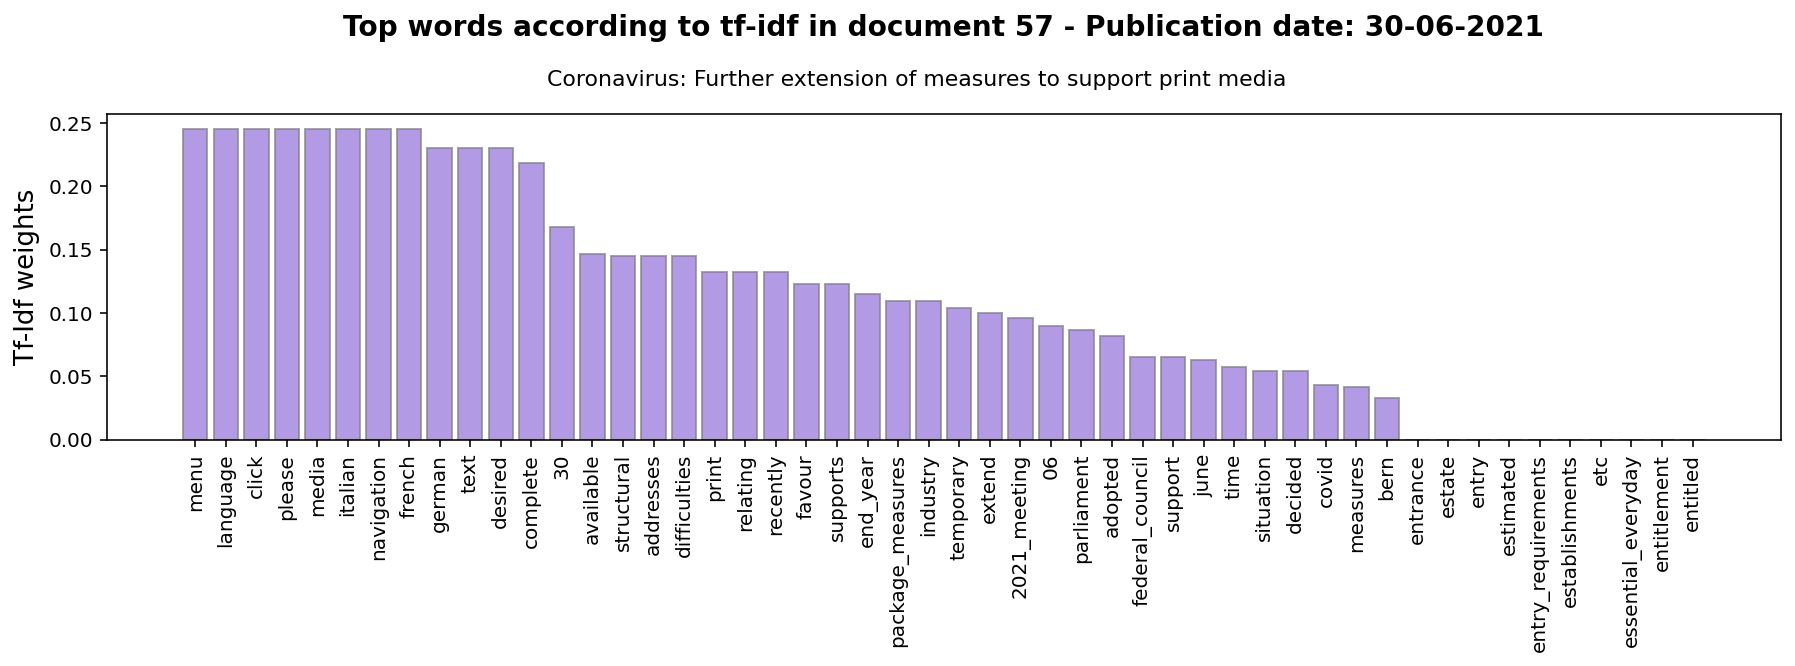

In [42]:
# Plots top words according to tf-idf scores

# Barplot and font specifications
barplot_specs   = {"color": "mediumpurple", "alpha": 0.7, "edgecolor": "grey"}
title_specs     = {"fontsize": 14, "fontweight": "bold", "y": 1.2}
suptitle_specs  = {"fontsize": 11}
label_specs     = {"fontsize": 13}

plt.figure(figsize=(15,3))

plt.bar(x = features_sorted,
        height=tfidf_weights_sorted,
        **barplot_specs)

plt.title('Top words according to tf-idf in document {} - Publication date: {}'.format(idx,df.iloc[idx,1].strftime("%d-%m-%Y")), **title_specs)
plt.suptitle(df.iloc[idx,0],**suptitle_specs)
plt.ylabel('Tf-Idf weights', **label_specs)
plt.xticks(rotation=90)
plt.show()

Don’t hesitate to compare this approach with the topmost frequent words for the same press release. Hopefully, diminishing the importance of widespread words across all documents has helped to focus on rare words that are more informative about the content of individual press releases. 
* Working with text data requires preprocessing to remove unnecessary words and reduce variability by standardizing words into a common form.
* Word frequencies can reveal information about the content of a document.
* Tf-idf weighting allows focusing less on widespread words across all documents in a dataset and more on words that occur in a small fraction of the corpus.